In [1]:
import sys
from pathlib import Path
from os import getcwd
sys.path.append(str(Path(getcwd()).parent))

from datetime import date, timedelta
import codecs
import pandas as pd
import numpy as np


pd.set_option('display.max_columns', None)

from os.path import join

from bulletin import default_input, default_output
from bulletin.services.metabase import Metabase
from bulletin.systems.casos_confirmados import CasosConfirmados
from bulletin.systems.notifica import Notifica
from bulletin.utils.static import Municipios
from bulletin.utils.normalize import normalize_hash, normalize_labels, normalize_text, date_hash, normalize_number
from bulletin.utils import static
from bulletin.utils.xls_ import fit_cols
from bulletin.systems.esus import eSUS

from datetime import datetime


today = datetime.today()
ontem = today - timedelta(1)
anteontem = ontem - timedelta(1)


---------------------------------------------------------------

root: /home/vinnylg/projects/covid19datascience/bulletin
parent: /home/vinnylg/projects/covid19datascience
default_input: /home/vinnylg/projects/covid19datascience/input
default_output: /home/vinnylg/projects/covid19datascience/output

---------------------------------------------------------------



In [18]:
# faixa_etaria = [0,30,40,50,60,70,80,90,100]
# faixa_etaria_labels = ['err','0-29','30-39','40-49','50-59','60-69','70-79','80-89','90-99','>=100']
# faixa_etaria = [60,65,70,75,80,85,90]
# faixa_etaria_labels = ['0-59','60-64','65-69','70-74','75-79','80-84','85-89','>=90']
# faixa_etaria = [60,70,80,90]
# faixa_etaria_labels = ['0-59','60-69','70-79','80-89','>=90']
faixa_etaria = [0,10,20,30,40,50,60,70,80,90,100]
faixa_etaria_labels = ['err','0-9','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90-99','>=100']

In [3]:
esus = eSUS()
esus.load()

cols = ['cns','paciente','cpf','sexo','nome_mae','data_nascimento','idade','ibge_residencia','categoria','data_aplicacao','fabricante','grupo_atendimento','vacina_nome','dose','ibge_atendimento','hash_mae','hash_nasc']

In [4]:
if esus.df['cns'].isna().sum() != 0:
    raise Exception(f"{esus.df['cns'].isna().sum()} cns com valor nulo")

In [5]:
esus1dose = esus.df.loc[esus.df['dose']==1]
esus2dose = esus.df.loc[esus.df['dose']!=1]

In [6]:
vacinados = pd.merge(esus1dose,esus2dose,on='cns',how='outer',suffixes=['_1a_dose','_2a_dose'])

In [7]:
cols.remove('cns')
for col in cols:
    vacinados.loc[vacinados[f"{col}_1a_dose"].notna(), col] = vacinados.loc[vacinados[f"{col}_1a_dose"].notna(), f"{col}_1a_dose"]
    vacinados.loc[(vacinados[f"{col}_1a_dose"].isna()) & (vacinados[f"{col}_2a_dose"].notna()), col] = vacinados.loc[(vacinados[f"{col}_1a_dose"].isna()) & (vacinados[f"{col}_2a_dose"].notna()), f"{col}_2a_dose"]
    vacinados.loc[(vacinados[f"{col}_1a_dose"].isna()) & (vacinados[f"{col}_2a_dose"].isna()), col] = None

vacinados['idade'] = vacinados['idade'].fillna(-99).astype(int)
vacinados['ibge_residencia'] = vacinados['ibge_residencia'].fillna(-999999).astype(int)
vacinados['ibge_atendimento'] = vacinados['ibge_atendimento'].fillna(-999999).astype(int)

In [8]:
# vacinados.loc[(vacinados['paciente_2dose'].notna()) & (vacinados['paciente_1dose'].notna()) & (vacinados['paciente_1dose']!=vacinados['paciente_2dose']),['paciente_1dose','paciente_2dose']]

In [9]:
vacinados = vacinados[['cns','paciente','cpf','sexo','nome_mae','data_nascimento','idade','ibge_residencia','ibge_atendimento','categoria','grupo_atendimento','fabricante','vacina_nome','data_aplicacao_1a_dose','data_aplicacao_2a_dose','hash_mae','hash_nasc']]

<AxesSubplot:xlabel='dias_entre_doses'>

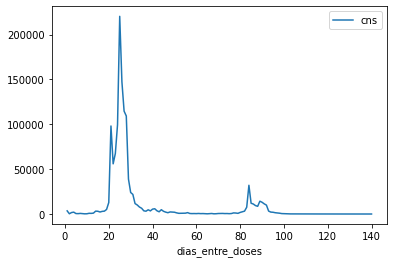

In [10]:
vacinados.loc[(vacinados['data_aplicacao_1a_dose'].notnull()) & (vacinados['data_aplicacao_2a_dose'].notnull()), 'dias_entre_doses'] = (
    vacinados.loc[(vacinados['data_aplicacao_1a_dose'].notnull()) & (vacinados['data_aplicacao_2a_dose'].notnull()), 'data_aplicacao_2a_dose'] -
    vacinados.loc[(vacinados['data_aplicacao_1a_dose'].notnull()) & (vacinados['data_aplicacao_2a_dose'].notnull()), 'data_aplicacao_1a_dose'])

vacinados.loc[vacinados['dias_entre_doses'].notnull(),'dias_entre_doses'] = vacinados.loc[vacinados['dias_entre_doses'].notnull(),'dias_entre_doses'].dt.days
vacinados.loc[(vacinados['dias_entre_doses'].isnull()) | (vacinados['dias_entre_doses'] < 0) ,'dias_entre_doses'] = 0

vacinados.loc[vacinados['dias_entre_doses']!=0,['cns','dias_entre_doses']].groupby('dias_entre_doses').count().plot()

In [11]:
vacinados['situacao'] = 'inconsistencia'
vacinados.loc[(vacinados['data_aplicacao_1a_dose'].notnull()) & (vacinados['data_aplicacao_2a_dose'].isnull()), 'situacao'] = 'só primeira dose'
vacinados.loc[(vacinados['dias_entre_doses']>0), 'situacao'] = 'ambas doses aplicadas'
vacinados[['cns','situacao']].groupby('situacao').count()

,cns
situacao,
ambas doses aplicadas,1297371
inconsistencia,90064
só primeira dose,1811924


<AxesSubplot:xlabel='dias_apos_ultima_dose'>

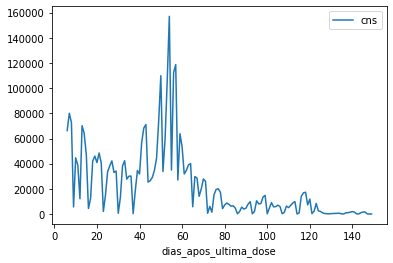

In [12]:
vacinados['data_ultima_dose'] = vacinados['data_aplicacao_1a_dose']
vacinados.loc[vacinados['data_aplicacao_2a_dose'].notna(),'data_ultima_dose'] = vacinados.loc[vacinados['data_aplicacao_2a_dose'].notna(),'data_aplicacao_2a_dose']
vacinados['dias_apos_ultima_dose'] = (vacinados['data_ultima_dose'] - today).dt.days * -1
vacinados[['cns','dias_apos_ultima_dose']].groupby('dias_apos_ultima_dose').count().plot()

<AxesSubplot:xlabel='faixa_etaria'>

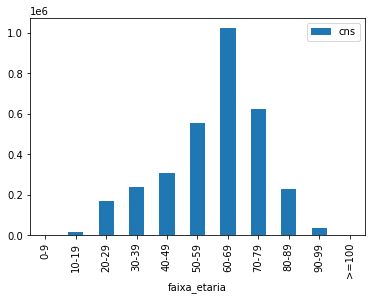

In [19]:
vacinados.loc[(vacinados['data_nascimento'].notnull()) & (vacinados['data_ultima_dose'].notnull()), 'idade'] = \
    vacinados.loc[(vacinados['data_nascimento'].notnull()) & (vacinados['data_ultima_dose'].notnull())].apply(
            lambda row: row['data_ultima_dose'].year - row['data_nascimento'].year - (
                    (row['data_ultima_dose'].month, row['data_ultima_dose'].day) <
                    (row['data_nascimento'].month, row['data_nascimento'].day)
            ), axis=1
    )

vacinados['faixa_etaria'] = [ faixa_etaria_labels[idx] for idx in np.digitize(vacinados['idade'],faixa_etaria,right=False)]
vacinados[['cns','faixa_etaria']].groupby('faixa_etaria').count().plot(kind='bar')

In [14]:
bins = [1,2,3,7,14,21,30,60,90]
bins_label = ['hoje','24 horas','48 horas', '72 horas', '7 dias', '14 dias', '21 dias', '30 dias', '60 dias', '90 dias']
vacinados['periodo_ultima_dose'] = [ x for x in np.digitize(vacinados['dias_apos_ultima_dose'],bins,right=False)]
dias_apos_ultima_dose = vacinados.groupby(['situacao','periodo_ultima_dose'])[['cns']].count().unstack().fillna(0).astype(int).rename(columns={'cns':'qtde'}).droplevel(0,1)
dias_apos_ultima_dose['total'] = dias_apos_ultima_dose.sum(1)
dias_apos_ultima_dose = dias_apos_ultima_dose.append(pd.DataFrame(dias_apos_ultima_dose.sum().tolist(),index=dias_apos_ultima_dose.columns.tolist(),columns=['total']).T)
dias_apos_ultima_dose.columns = [ bins_label[bins] if isinstance(bins,int) else bins for bins in dias_apos_ultima_dose.columns ]
dias_apos_ultima_dose = dias_apos_ultima_dose.reset_index()
dias_apos_ultima_dose.index = [0,2,1,3]
dias_apos_ultima_dose = dias_apos_ultima_dose.sort_index().set_index('index')
dias_apos_ultima_dose.index.name = None
dias_apos_ultima_dose

,72 horas,7 dias,14 dias,21 dias,30 dias,60 dias,90 dias,total
ambas doses aplicadas,2675,30471,49925,41718,671105,312764,188713,1297371
só primeira dose,63519,293003,205424,243896,790798,160352,54932,1811924
inconsistencia,95,909,1360,2150,58889,14935,11726,90064
total,66289,324383,256709,287764,1520792,488051,255371,3199359


In [51]:
notifica = Notifica()
notifica.load()
casos_confirmados = notifica.df
casos_confirmados['faixa_etaria'] = [ faixa_etaria_labels[idx] for idx in np.digitize(casos_confirmados['idade'],faixa_etaria,right=False)]
casos_confirmados['ano_caso'] = casos_confirmados['data_diagnostico'].apply(lambda x: x.year if isinstance(x,date) else 'erro')
casos_confirmados['mes_caso'] = casos_confirmados['data_diagnostico'].apply(lambda x: x.month if isinstance(x,date) else 'erro')
casos_confirmados['ano_obito'] = casos_confirmados['data_cura_obito'].apply(lambda x: x.year if isinstance(x,date) else 'erro')
casos_confirmados['mes_obito'] = casos_confirmados['data_cura_obito'].apply(lambda x: x.month if isinstance(x,date) else 'erro')

In [53]:
casos_vacinados_cns = pd.merge(vacinados,casos_confirmados[['cns','id','data_diagnostico','evolucao','data_cura_obito']], on='cns', how='inner')
print(len(casos_vacinados_cns))

casos_vacinados_cpf = pd.merge(vacinados.loc[vacinados['cpf'].notna()],casos_confirmados[['cpf','id','data_diagnostico','evolucao','data_cura_obito']], on='cpf', how='inner')
print(len(casos_vacinados_cpf))

casos_vacinados_mae = pd.merge(vacinados.loc[vacinados['hash_mae'].notna()],casos_confirmados[['hash_mae','id','data_diagnostico','evolucao','data_cura_obito']], on='hash_mae', how='inner')
print(len(casos_vacinados_mae))

casos_vacinados_nasc = pd.merge(vacinados.loc[vacinados['hash_nasc'].notna()],casos_confirmados[['hash_nasc','id','data_diagnostico','evolucao','data_cura_obito']], on='hash_nasc', how='inner')
print(len(casos_vacinados_nasc))

casos_vacinados = pd.concat([casos_vacinados_cns,casos_vacinados_cpf,casos_vacinados_mae,casos_vacinados_nasc])
casos_vacinados = casos_vacinados.drop_duplicates('id', keep='first')
print(len(casos_vacinados))

268582
0
258626
307464
292017


In [54]:
casos_vacinados

,cns,paciente,cpf,sexo,nome_mae,data_nascimento,idade,ibge_residencia,ibge_atendimento,categoria,grupo_atendimento,fabricante,vacina_nome,data_aplicacao_1a_dose,data_aplicacao_2a_dose,hash_mae,hash_nasc,dias_entre_doses,situacao,data_ultima_dose,dias_apos_ultima_dose,faixa_etaria,periodo_ultima_dose,id,data_diagnostico,evolucao,data_cura_obito
0,708204618070445,APARECIDO PROCOPIO DOS SANTOS,None,M,OLINDA MARIA DE JESUS,1938-12-20,82,411520,411210,Pessoas de 60 anos ou mais institucionalizadas,Pessoas de 60 nos ou mais Institucionalizadas,Covid-19 - Coronavac,Covid-19-Coronavac-Sinovac/Butantan,2021-01-13,2021-02-12,APARECIDOPROCOPIODOSSANTOSOLINDAMARIADEJESUS,APARECIDOPROCOPIODOSSANTOS20121938,30,ambas doses aplicadas,2021-02-12,123,80-89,9,3865742,2021-05-25,3.0,NaT
1,700001852764702,NOELY ANGELA FIGUEREDO GENOVESI,None,F,VANILDA CARNEIRO DE FIGUEREDO,1977-12-23,43,410380,411210,Trabalhadores de Saúde,Enfermeiro(a),Covid-19 - Coronavac,Covid-19-Coronavac-Sinovac/Butantan,2021-01-11,2021-02-12,NOELYANGELAFIGUEREDOGENOVESIVANILDACARNEIRODEF...,NOELYANGELAFIGUEREDOGENOVESI23121977,32,ambas doses aplicadas,2021-02-12,123,40-49,9,3966682,2021-05-31,3.0,NaT
2,708705169781990,BENEDITO ROBERTO MOREIRA,None,M,BENEDITA MOREIRA,1969-09-30,51,411550,411550,Trabalhadores de Saúde,Motorista de Ambulância,FUNDACAO BUTANTAN,Covid-19-Coronavac-Sinovac/Butantan,2021-01-19,2021-02-15,BENEDITOROBERTOMOREIRABENEDITAMOREIRA,BENEDITOROBERTOMOREIRA30091969,27,ambas doses aplicadas,2021-02-15,120,50-59,9,3709182,2021-05-18,1.0,2021-05-27
3,702309148230616,JANE RODRIGUES NOGUEIRA,None,F,APARECIDA DA CONCEICAO NOGUEIRA,1975-01-24,46,411820,411820,Trabalhadores de Saúde,Fisioterapeutas,FUNDACAO BUTANTAN,Covid-19-Coronavac-Sinovac/Butantan,2021-01-19,2021-02-17,JANERODRIGUESNOGUEIRAAPARECIDADACONCEICAONOGUEIRA,JANERODRIGUESNOGUEIRA24011975,29,ambas doses aplicadas,2021-02-17,118,40-49,9,409221,2020-07-14,1.0,2020-07-14
4,704807098447447,LADISLAO OBRZUT NETO,None,M,EVANDROLINA SABOIA OBRZUT,1955-12-25,65,411070,411070,Trabalhadores de Saúde,Médico,FUNDACAO BUTANTAN,Covid-19-Coronavac-Sinovac/Butantan,2021-01-19,2021-02-12,LADISLAOOBRZUTNETOEVANDROLINASABOIAOBRZUT,LADISLAOOBRZUTNETO25121955,24,ambas doses aplicadas,2021-02-12,123,60-69,9,3208382,2021-03-12,1.0,2021-03-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307056,898000750971489,JANAINA DE BRITO,071.162.798-30,F,DILMA MOREIRA ANTUNES DE BRITO,1980-03-06,41,-999999,411520,Trabalhadores de Saúde,Outros,SINOVAC - BUTANTAN,Covid-19-Coronavac-Sinovac/Butantan,NaT,2021-05-11,JANAINADEBRITODILMAMOREIRAANTUNESDEBRITO,JANAINADEBRITO06031980,0,inconsistencia,2021-05-11,35,40-49,7,3380029,2021-04-06,1.0,2021-04-23
307117,898003204038981,AMELIA LUIZ PEREIRA,None,F,MARIA PEREIRA BRITO,1952-07-13,68,-999999,410140,Faixa Etária,Pessoas de 70 a 74 anos,FUNDACAO BUTANTAN,Covid-19-Coronavac-Sinovac/Butantan,NaT,2021-05-13,AMELIALUIZPEREIRAMARIAPEREIRABRITO,AMELIALUIZPEREIRA13071952,0,inconsistencia,2021-05-13,33,60-69,7,2181497,2020-12-28,3.0,NaT
307420,706806277858625,REINIER SILVIO FERREIRA,839.517.769-000,M,None,1974-12-10,46,410480,410480,Funcionário do Sistema de Privação de Liberdade,Funcionário do Sistema de Privação de Liberdade,FUNDACAO OSWALDO CRUZ,Vacina Covid-19 - Covishield,NaT,2021-06-07,None,REINIERSILVIOFERREIRA10121974,0,inconsistencia,2021-06-07,8,40-49,4,306485,2020-07-14,1.0,2020-09-25
307424,704608147438623,LUIZ GERALDO DA SILVA CARDOSO,754.081.494-20,M,None,1986-12-24,34,410480,410480,Pessoas com Deficiência,Pessoas com Deficiências Permanente Grave,FUNDACAO OSWALDO CRUZ,Vacina Covid-19 - Covishield,NaT,2021-06-07,None,LUIZGERALDODASILVACARDOSO24121986,0,inconsistencia,2021-06-07,8,30-39,4,305045,2020-07-03,1.0,2020-09-02


In [55]:
casos_vacinados[['id','evolucao']].groupby('evolucao').count()

,id
evolucao,
1.0,194505
2.0,3956
3.0,64054
4.0,44


In [56]:
casos_vacinados.loc[(casos_vacinados['situacao']=='ambas doses aplicadas') & (casos_vacinados['data_diagnostico'] > casos_vacinados['data_aplicacao_2a_dose']) | (casos_vacinados['dias_apos_ultima_dose'] > 14),'vacinado'] = 2
casos_vacinados.loc[(casos_vacinados['data_diagnostico'] > casos_vacinados['data_aplicacao_1a_dose']) | (casos_vacinados['dias_apos_ultima_dose'] <= 14),'vacinado'] = 1
casos_vacinados.loc[(casos_vacinados['data_diagnostico'] < casos_vacinados['data_aplicacao_1a_dose']) | (casos_vacinados['data_aplicacao_1a_dose'].isna() & (casos_vacinados['data_diagnostico'] < casos_vacinados['data_aplicacao_2a_dose'])),'vacinado'] = 0

casos = pd.merge(casos_confirmados,casos_vacinados[['id','categoria','grupo_atendimento','fabricante','vacina_nome','situacao','vacinado']],how='left',on='id')
casos['vacinado'] = casos['vacinado'].fillna(0)
grupo = casos.groupby(['ano_caso','mes_caso','faixa_etaria','vacinado'])[['id']].count().unstack(-2)
grupo = grupo.droplevel(0,1)
grupo = grupo.fillna(0).astype(int)
grupo

faixa_etaria                 0-9  10-19  20-29  30-39  40-49  50-59  60-69  \
ano_caso mes_caso vacinado                                                   
2020.0   3.0      0.0          7     17     69     88     67     54     29   
         4.0      0.0         26     66    288    363    317    242    114   
         5.0      0.0        135    206   1075   1269   1096    779    395   
         6.0      0.0        755   1602   6719   7684   6440   4608   2267   
         7.0      0.0       1689   3404  12393  13683  11338   8383   4511   
         8.0      0.0       1621   3629  11701  12677  10490   8126   4404   
         9.0      0.0       1183   3025   9736  10215   8637   6446   3627   
         10.0     0.0        999   2418   7754   7992   6303   4739   2762   
         11.0     0.0       2365   7537  24976  24089  19186  14544   8178   
         12.0     0.0       2703   8491  25749  28157  23491  18438  10757   
2021.0   1.0      0.0       3027   8444  23381  24013  20097  16038   9818   
                  1.0          0      3     86    141    113     66     24   
                  2.0          0      0      3      3      2      1      1   
         2.0      0.0       2599   8085  20735  21950  18780  15315   9428   
                  1.0          1     39    570    971    835    484    128   
                  2.0          0      0      6      9      5      3      0   
         3.0      0.0       5226  12412  29325  31227  28048  23082  14083   
                  1.0          0     37    668   1128    911    573    217   
                  2.0          0      0     15     18     12      9     13   
         4.0      0.0       3740   7832  16624  17809  16068  13166   5822   
                  1.0          0     33    541    800    702    377   2427   
                  2.0          0      0      8     11     17      5     31   
         5.0      0.0       7136  15641  33200  35256  31619  24481   2400   
                  1.0          1     80   1111   1667   1690   2867   9653   
                  2.0          1      0     24     35     36     31     53   
         6.0      0.0       2551   5779  11992  12809  11512   8312    596   
                  1.0          0     53    709   1118   1586   2542   3497   
                  2.0          1      0     10      6      8      6     22   

faixa_etaria                70-79  80-89  90-99  >=100  err  
ano_caso mes_caso vacinado                                   
2020.0   3.0      0.0          15      7      1      0    1  
         4.0      0.0          76     35      5      0    0  
         5.0      0.0         199     97      9      0    6  
         6.0      0.0        1047    462     90      4    9  
         7.0      0.0        2199    907    208      8   24  
         8.0      0.0        2075    873    195      5    5  
         9.0      0.0        1733    666    145      5    1  
         10.0     0.0        1264    540     95      2    1  
         11.0     0.0        3577   1248    230      7    3  
         12.0     0.0        5137   1907    316     19    9  
2021.0   1.0      0.0        4836   1770    325     12   14  
                  1.0          16     24     13      0    0  
                  2.0           0      0      2      0    0  
         2.0      0.0        4633   1549    160      8    9  
                  1.0          38     96    117      5    0  
                  2.0           1      2      1      0    0  
         3.0      0.0        6040    931     61      6   10  
                  1.0         867   1503    310     13    0  
                  2.0          22     16      2      0    0  
         4.0      0.0         531    139     21      1    1  
                  1.0        3231    996    146      6    0  
                  2.0          22     13      3      0    0  
         5.0      0.0         426    192     31      1    2  
                  1.0        3733   1539    252     10    0  
                  2.0          58     29      3

In [58]:
obitos_vacinados = casos_vacinados.loc[casos_vacinados['evolucao']==2].copy()
obitos = casos_confirmados.loc[casos_confirmados['evolucao']==2]
obitos = pd.merge(obitos,obitos_vacinados[['id','categoria','grupo_atendimento','fabricante','vacina_nome','situacao','vacinado']],how='left',on='id')
obitos['vacinado'] = obitos['vacinado'].fillna(0)
grupo = casos.groupby(['ano_obito','mes_obito','faixa_etaria','vacinado'])[['id']].count().unstack(-2)
grupo = grupo.droplevel(0,1)
grupo = grupo.fillna(0).astype(int)
grupo

faixa_etaria                   0-9  10-19  20-29  30-39  40-49  50-59  60-69  \
ano_obito mes_obito vacinado                                                   
2020.0    3.0       0.0          0      1     11     14     11     11      3   
          4.0       0.0         11     20     77    106     79     77     33   
          5.0       0.0         34     63    254    327    300    179    114   
                    1.0          0      0      0      0      0      1      0   
          6.0       0.0        218    537   2171   2405   2057   1461    704   
          7.0       0.0        889   2035   7529   8056   6585   5006   2568   
                    1.0          0      0      0      1      1      0      0   
          8.0       0.0       1185   2850   9202   9909   8358   6251   3444   
                    1.0          0      0      0      1      1      0      0   
                    2.0          0      0      0      1      0      0      0   
          9.0       0.0        958   2566   8237   8747   7432   5486   3088   
                    1.0          0      0      0      0      1      0      0   
          10.0      0.0        605   1609   5127   5519   4448   3416   2056   
                    1.0          0      0      0      0      1      0      0   
          11.0      0.0        909   2818   9594   9157   7099   5319   3097   
                    1.0          0      0      1      2      0      1      0   
          12.0      0.0       1494   5388  17031  17617  14513  11547   6780   
                    1.0          0      0      1      1      1      1      1   
2021.0    1.0       0.0       1833   5218  14688  15440  12770  10284   6621   
                    1.0          0      2     19     22     23      6      6   
                    2.0          0      0      1      1      0      0      1   
          2.0       0.0       1374   4405  11398  11792  10103   8213   5137   
                    1.0          0     15    260    428    328    197     67   
                    2.0          0      0      2      3      3      2      0   
          3.0       0.0       3103   7945  18857  19919  17579  14542   9288   
                    1.0          1     37    412    695    593    360    118   
                    2.0          0      0      9     17      8      4      5   
          4.0       0.0       2902   6724  14256  15167  13672  11465   6778   
                    1.0          0     26    340    582    471    279    803   
                    2.0          0      0      8     10     12      3      7   
          5.0       0.0       3412   7317  15329  16153  14614  11818   2862   
                    1.0          0     24    431    658    681    622   3911   
                    2.0          0      0      9     15     17     13     32   
          6.0       0.0       1935   4306   8863   9321   8166   6311    699   
                    1.0          0     29    333    534    625   1208   2390   
                    2.0          1      0      6      8      9      5      8   

faixa_etaria                  70-79  80-89  90-99  >=100  err  
ano_obito mes_obito vacinado                                   
2020.0    3.0       0.0           1      1      0      0    0  
          4.0       0.0          26     16      6      0    0  
          5.0       0.0          50     27      4      0    0  
                    1.0           0      0      0      0    0  
          6.0       0.0         400    195     41      3    3  
          7.0       0.0        1322    571    121      7    1  
                    1.0           0      0      0      0    0  
          8.0       0.0        1596    725    158      5    1  
                    1.0           0      0      0      0    0  
                    2.0           0      0      0      0    0  
          9.0       0.0        1540    598    141      6    0  
                    1.0           0      0      0      0    0  
          10.0      0.0         997    419     83      3    0  

In [ ]:
#comorbidades. !TODO 
casos_vacinados_comorbidade = pd.merge(casos_vacinados, comorbidades,how='left',on='id')

#mes - vacinado - for comorbidade em total com comorbidade - com comorbidade - sem comorbidade
grupo = casos.groupby(['ano_obito','mes_obito','vacinado'])[notifica.schema['comorbidades']].sum()
# grupo = grupo.droplevel(0,1)
grupo = grupo.fillna(0).astype(int)

grupo